In [3]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv('/content/drive/MyDrive/all_faults.csv')

feature extraction

In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=784
stride=450

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [7]:
X.shape

(6169, 784, 1)

Data split


In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)


CNN　Model

In [9]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D



# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')



no_classes = len(df['fault'].unique())

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=100, activation='relu', input_shape=(X.shape[1],X.shape[2])))
cnn_model.add(Conv1D(filters=32, kernel_size=50, activation='relu'))

cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))


cnn_model.add(Dense(no_classes, activation='softmax'))

cnn_model.summary()

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 685, 64)        │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 636, 32)        │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 159, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5088)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       508,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,210 (2.36 MB)

 Trainable params: 619,210 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

train cnn

In [10]:
batch_size =300
epochs = 5
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - accuracy: 0.2162 - loss: 2.2359 - val_accuracy: 0.5451 - val_loss: 1.3169
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.5946 - loss: 1.1373 - val_accuracy: 0.7380 - val_loss: 0.7877
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 85s 6s/step - accuracy: 0.7977 - loss: 0.6649 - val_accuracy: 0.8531 - val_loss: 0.5040
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.8680 - loss: 0.3984 - val_accuracy: 0.9341 - val_loss: 0.2514
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 146s 6s/step - accuracy: 0.9445 - loss: 0.1906 - val_accuracy: 0.9584 - val_loss: 0.1321


accuracy graph

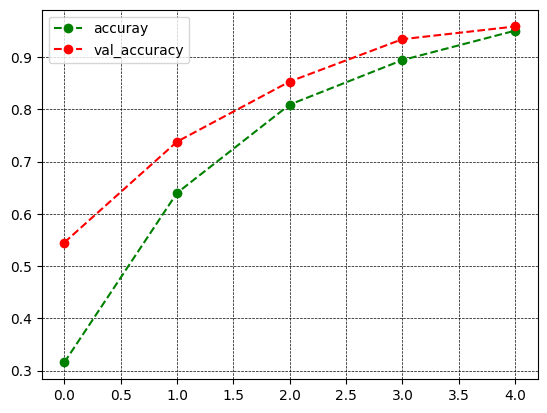

In [11]:
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['accuray','val_accuracy'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

confusion matrix

58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step


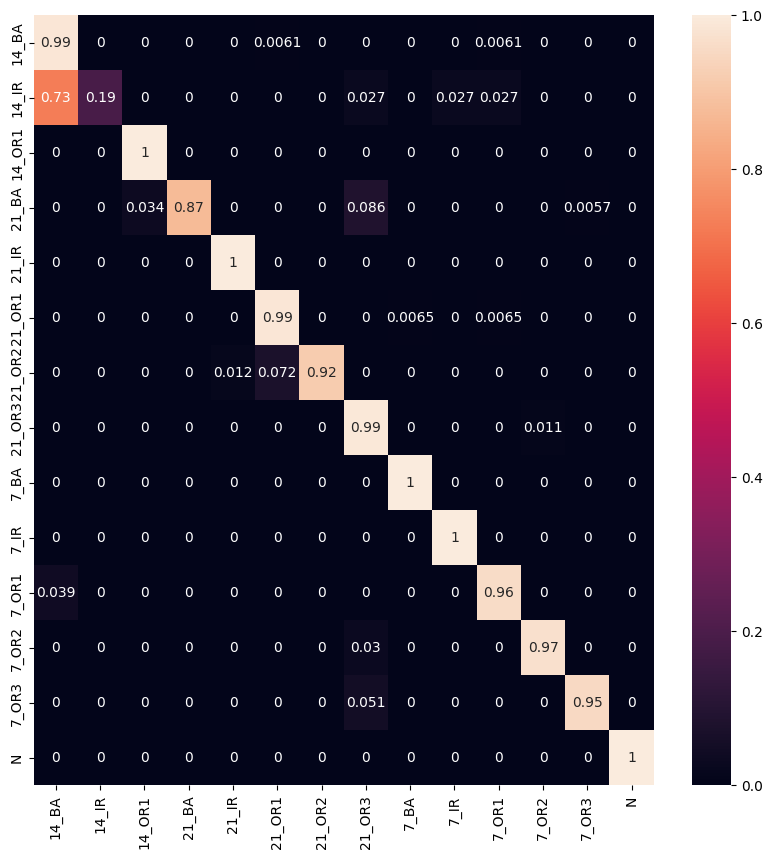

In [12]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [13]:
dummy_cnn = Model(inputs=cnn_model.layers[0].input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)

135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step


T-SNE plot after CNN

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4318 samples in 0.036s...
[t-SNE] Computed neighbors for 4318 samples in 0.251s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4318
[t-SNE] Computed conditional probabilities for sample 2000 / 4318
[t-SNE] Computed conditional probabilities for sample 3000 / 4318
[t-SNE] Computed conditional probabilities for sample 4000 / 4318
[t-SNE] Computed conditional probabilities for sample 4318 / 4318
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.511715
[t-SNE] KL divergence after 300 iterations: 1.195820


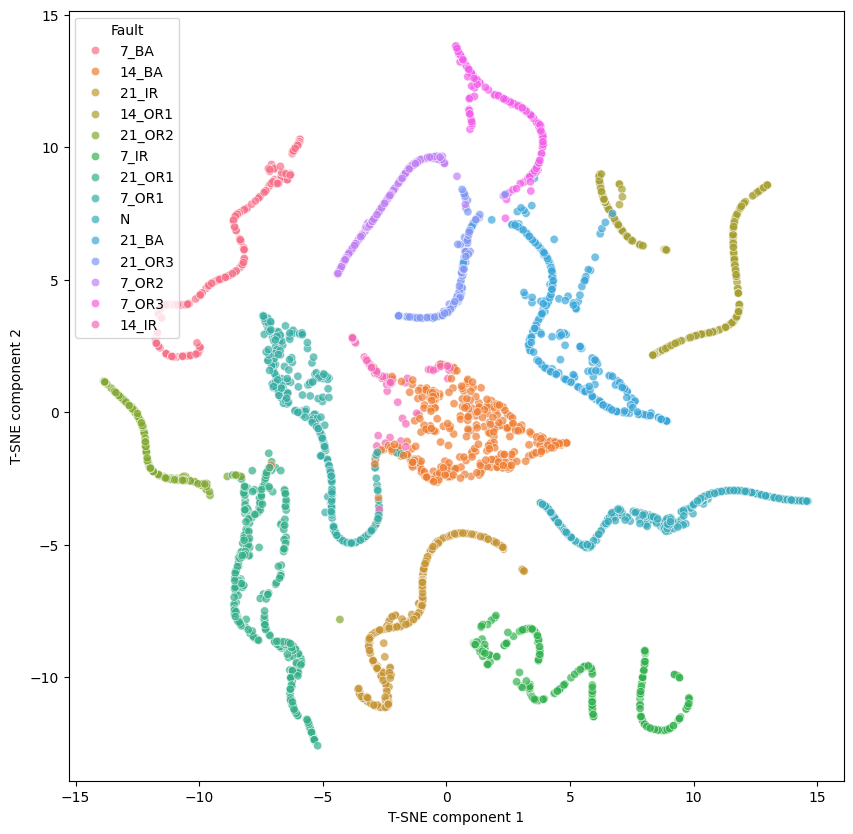

In [14]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.7)
plt.show()